In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
print("hello")

hello


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

2024-02-24 07:08:24.402823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 07:08:24.402965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 07:08:24.521247: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [5]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",
                 encoding='latin',
                 header=None)

In [6]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.columns = ["sentiment","id","date","query","user_name","text"]

In [8]:
df.head()

,sentiment,id,date,query,user_name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.drop(columns=["id","date","query","user_name"],inplace=True)

In [10]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [12]:
df.sentiment.nunique()

2

In [13]:
df.sentiment.unique()

array([0, 4])

In [14]:
df.sentiment = df.sentiment.map({0:"Negative",4:"Positive"})

In [15]:
df.sentiment.unique()

array(['Negative', 'Positive'], dtype=object)

In [16]:
df.sentiment.value_counts(normalize=True)

sentiment
Negative    0.5
Positive    0.5
Name: proportion, dtype: float64

<Axes: xlabel='sentiment', ylabel='count'>

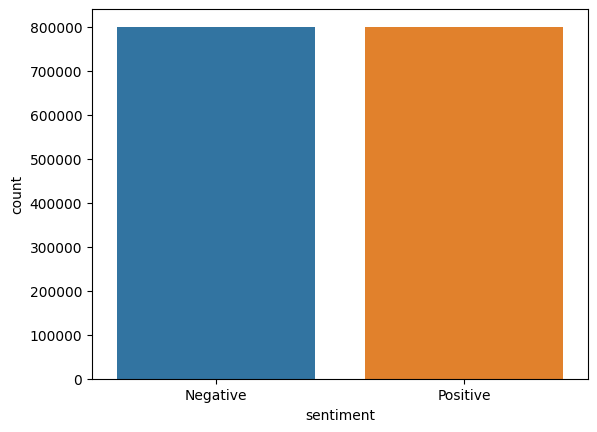

In [17]:
sns.countplot(x=df.sentiment)

In [18]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [19]:
re_epr = "@\S+|http:\S+|[^A-Za-z0-9]+"
a=re.sub(re_epr," ",df.text[0])
a.strip()

'Awww that s a bummer You shoulda got David Carr of Third Day to do it D'

In [20]:
b = "@ram how @are you ?"
rex = "@\S+"
re.sub(rex,"",b)

' how  you ?'

In [21]:
from nltk.corpus import stopwords

In [22]:
stemmer = SnowballStemmer('english')

In [23]:
stop_word = stopwords.words('english')

In [24]:
def proc_data(seq, stem=True):
    regx = "@\S+|http:\S+|[^A-Za-z0-9]+"
    s = re.sub(regx," ",str(seq))
    s=s.split()
    out = []
    for i in s:
        if i not in stop_word:
            if stem:
                out.append(stemmer.stem(i))
            else:
                out.append(i)
    return " ".join(out)
            
        

In [25]:
s = "@am http:sdf.com helklo hello bathing bath writes writing"
x=proc_data(s)
print(x)

helklo hello bath bath write write


In [26]:
x=proc_data(s,stem=True)
print(x)

helklo hello bath bath write write


In [27]:
df.text = df.text.apply(proc_data)

In [28]:
df.head()

,sentiment,text
0,Negative,awww bummer you shoulda got david carr third d...
1,Negative,upset updat facebook text might cri result sch...
2,Negative,i dive mani time ball manag save 50 the rest g...
3,Negative,whole bodi feel itchi like fire
4,Negative,behav mad i see


In [29]:
#df.sentiment = df.sentiment.map({0:"Negative",4:"Positive"})

In [30]:
df.head()

,sentiment,text
0,Negative,awww bummer you shoulda got david carr third d...
1,Negative,upset updat facebook text might cri result sch...
2,Negative,i dive mani time ball manag save 50 the rest g...
3,Negative,whole bodi feel itchi like fire
4,Negative,behav mad i see


In [31]:
train,test = train_test_split(df,test_size=0.2,random_state=3)

In [32]:
train.shape

(1280000, 2)

In [33]:
test.shape

(320000, 2)

In [34]:
type(train)

pandas.core.frame.DataFrame

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [36]:
token = Tokenizer(oov_token='#OOV')
token.fit_on_texts(df.text)
vocab_size = len(token.word_index)
print(vocab_size)

288547


In [37]:
x_train = pad_sequences(token.texts_to_sequences(train.text),maxlen=30)
x_test = pad_sequences(token.texts_to_sequences(test.text),maxlen=30)

In [38]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  16, 480,  89], dtype=int32)

In [39]:
le = LabelEncoder()
y_train = le.fit_transform(train.sentiment)
y_test = le.transform(test.sentiment)

In [40]:
y_train = y_train.reshape(-1, 1)
y_test  = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

(1280000, 1)
(320000, 1)


In [41]:
pwd

'/kaggle/working'

In [42]:
ls

__notebook__.ipynb


In [43]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-02-24 07:14:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-24 07:14:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-24 07:14:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [44]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [45]:
rm glove.6B.zip

In [46]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR =0.01
BATCH_SIZE = 1024
EPOCHS = 40
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [47]:
embedding_index = {}
f = open(GLOVE_EMB)
for l in f:
    val = l.split()
    word = val[0]
    vec = np.asarray(val[1:],dtype='float')
    embedding_index[word]= vec
f.close()
print(f"found {len(embedding_index)} words")

found 400000 words


In [48]:
#list(embedding_index.items())[0]

In [49]:
token_index = token.word_index
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
for w,i in token_index.items():
    vec = embedding_index.get(w)
    if vec is not None:
        embedding_matrix[i]=vec

In [50]:
embedding_matrix[2]

array([-1.3292e-01,  1.6985e-01, -1.4360e-01, -8.8722e-02,  7.9510e-02,
       -1.4212e-01, -2.4209e-02, -2.6291e-01, -7.4814e-02, -2.3600e+00,
        3.4830e-01, -9.1722e-02, -5.3906e-02,  3.0418e-01, -1.3286e-01,
        5.0341e-03, -1.5056e-01,  2.3562e-03,  6.8321e-02,  3.4246e-01,
        3.9891e-01,  5.8813e-01,  6.0618e-02, -1.9871e-01, -4.0465e-01,
       -1.0706e-01, -5.9312e-03, -6.4842e-01,  1.9080e-01, -1.7630e-01,
        9.2407e-02,  3.8685e-01, -3.1085e-01, -3.2574e-01, -1.6823e+00,
        2.5336e-01, -2.4647e-01, -1.0874e-01,  7.6402e-03,  3.3880e-01,
       -5.9736e-02, -8.5940e-01, -8.0964e-02, -2.2981e-01,  1.7709e-01,
        8.2094e-02,  7.4416e-01,  3.6873e-01,  1.3740e-01,  2.9408e-01,
        1.0647e-01, -1.3246e-01,  1.2134e-01, -1.4273e-01, -5.3270e-01,
        6.4936e-01,  4.9657e-01,  3.0029e-01,  6.7226e-01,  1.8005e-01,
        8.8050e-01,  3.8144e-02, -8.7140e-02,  7.6400e-01, -1.2107e-01,
       -4.2809e-01, -1.2588e-01,  8.8377e-04,  1.0596e-01, -3.08

In [51]:
MAX_SEQ_LENGTH = 30
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQ_LENGTH,
                                            trainable = False)

In [52]:
from tensorflow.keras.layers import Conv1D,Bidirectional,Dense, Input, Dropout, LSTM
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

# "Sequenctial way"
model = tf.keras.Sequential()
# Feature extractor
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(64,5, activation='relu'))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout = 0.2)))

# Fully connected part
# Probability Mapper
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [53]:
# "Functional way" of creating model architecture
sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedding_sequence = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequence)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout = 0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input,outputs)

In [54]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [55]:
model.compile(loss='binary_crossentropy',
             optimizer=Adam(learning_rate=0.01),
             metrics = ['accuracy'])
LR_reduction = ReduceLROnPlateau(factor= 0.1,
                                min_lr=0.0001,
                                monitor = 'val_loss',
                                verbose=1)

In [56]:
hist = model.fit(x_train,y_train,
                 batch_size=BATCH_SIZE,
                 epochs=10,
                 validation_data=(x_test,y_test),
                 callbacks=[LR_reduction])

Epoch 1/10


I0000 00:00:1708759104.802501      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 123s 92ms/step - loss: 0.5400 - accuracy: 0.7237 - val_loss: 0.5025 - val_accuracy: 0.7513 - lr: 0.0100
Epoch 2/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5116 - accuracy: 0.7462 - val_loss: 0.4979 - val_accuracy: 0.7544 - lr: 0.0100
Epoch 3/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5061 - accuracy: 0.7499 - val_loss: 0.4961 - val_accuracy: 0.7573 - lr: 0.0100
Epoch 4/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5033 - accuracy: 0.7517 - val_loss: 0.4960 - val_accuracy: 0.7569 - lr: 0.0100
Epoch 5/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5015 - accuracy: 0.7531 - val_loss: 0.4947 - val_accuracy: 0.7587 - lr: 0.0100
Epoch 6/10
1250/1250 [==============================] - 114s 91ms/step - loss: 0.5010 - accuracy: 0.7533 - val_loss: 0.4909 - val_accuracy: 0.7597 - lr: 0.0100
Epoch 7/10
1250/1250 [=============================

In [57]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])